# HDR

It consists of capturing multiple frames of the same scene but with different exposures and then combining them into one, resulting into an image with a dynamic range higher than the individually captured frames.

In [1]:
%matplotlib inline

In [2]:
import os
import cv2
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from PIL.ExifTags import TAGS

## Read and plot images

In [3]:
def exposureTime(files):
    exp_times = []
    for path in files:
        # open the image
        image = Image.open(path)
        exif_data = image._getexif()

        if not exif_data:
            pass

        # looping through all the tags present in exifdata
        for tag_id, value in exif_data.items():
            
            tag = TAGS.get(tag_id, tag_id)
            if tag == 'ExposureTime':
                exp_times.append(value)
        
    return exp_times

0


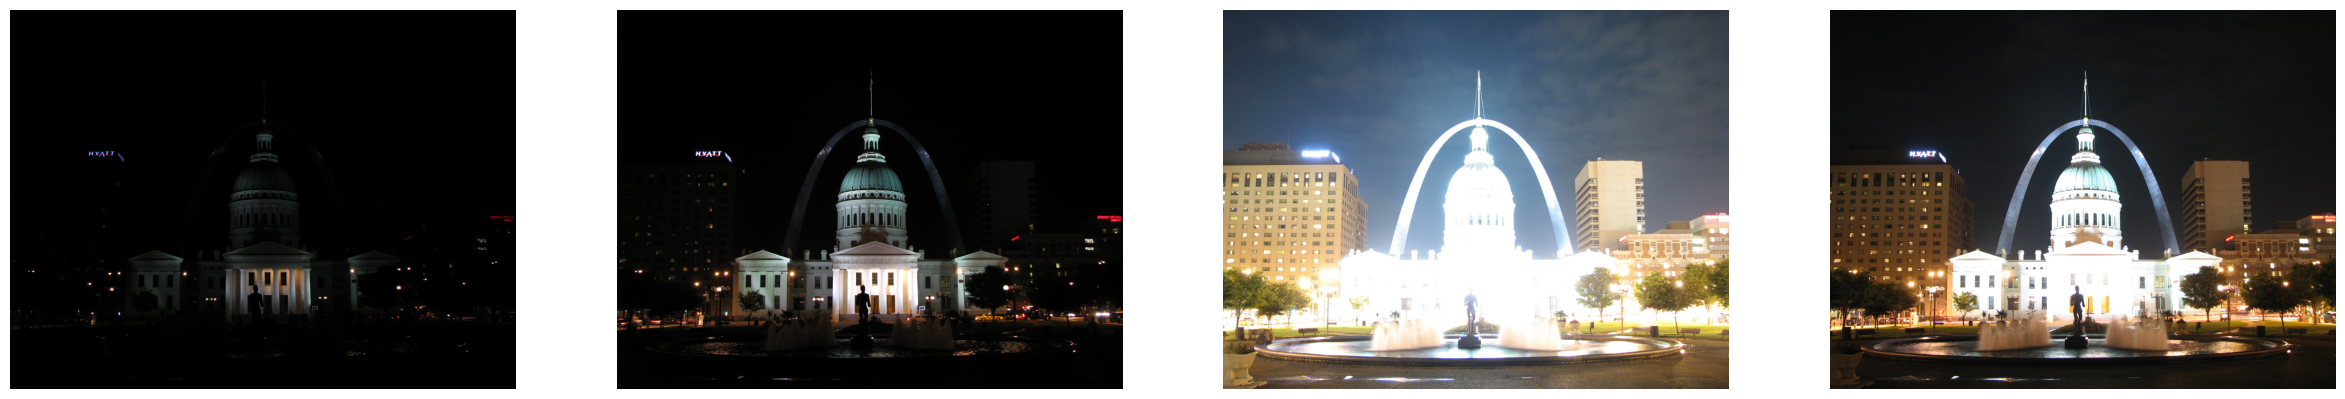

In [4]:
files = glob.glob("./Images/img*.jpg")
files.sort()

times = np.array(exposureTime(files), dtype=np.float32)
images = []
print(len(images))
for filename in files:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

plt.figure(figsize=[30,10])
cols = 4
rows = math.ceil(len(images)/cols)
for i in range(0, len(images)):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()


## Align Images

In [5]:
alignMTB = cv2.createAlignMTB() # Bit maps for alignement
alignMTB.process(images, images) # Align images

## Estimate camera response function

Cameras usually are not linear:  when the radiance in the scenes double the pixel intensity recorded not necesserally doubles. So we have to linearize before combining the images

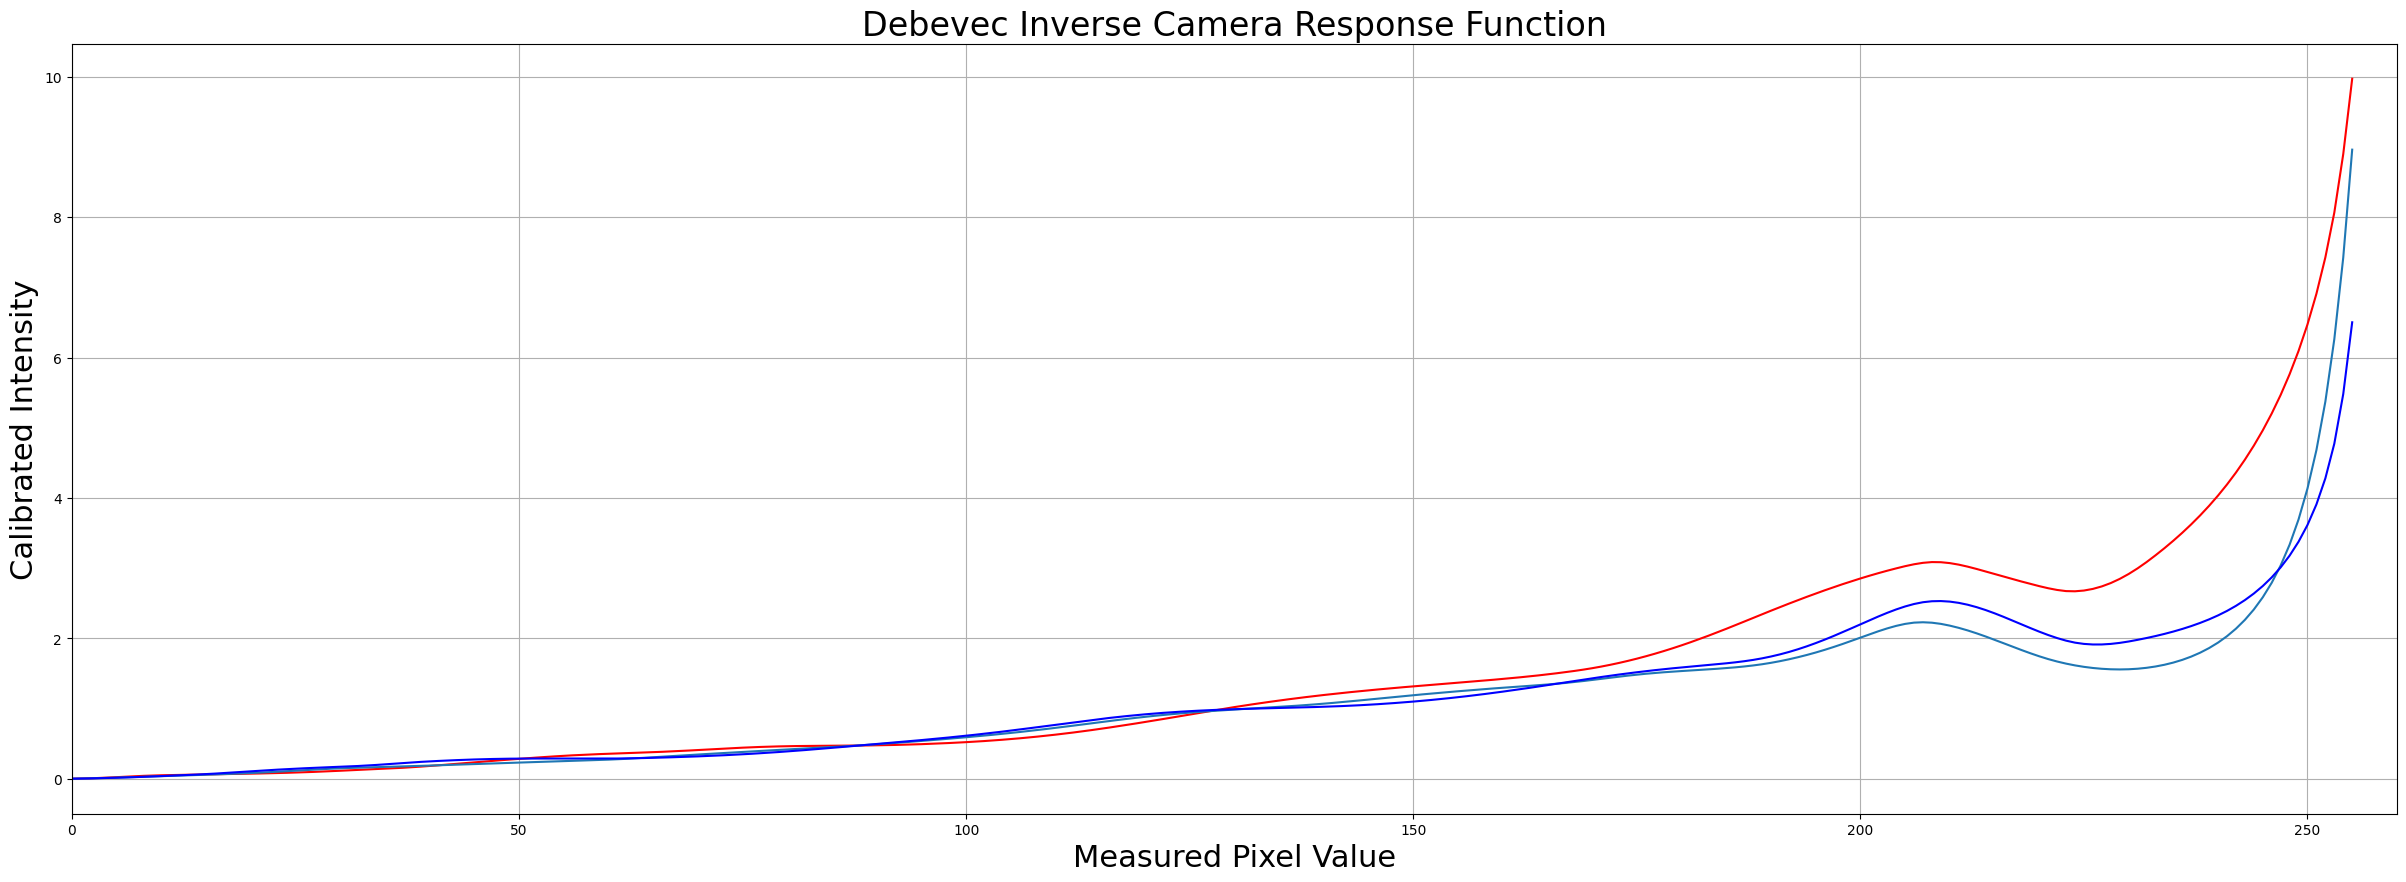

In [6]:
calibrateDebevec = cv2.createCalibrateDebevec() # Debevec or Robertson algorithms
responseDebevec =  calibrateDebevec.process(images, times)

x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30,10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22) 
plt.ylabel("Calibrated Intensity", fontsize=22) 
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:,0], 'r', x, y[:,1], x, y[:,2], 'b')

## Merge Exposure into HDR image

In [7]:
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

## Tonemapping

[ WARN:0@3.449] global matrix_expressions.cpp:1333 assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739
[ WARN:0@3.919] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


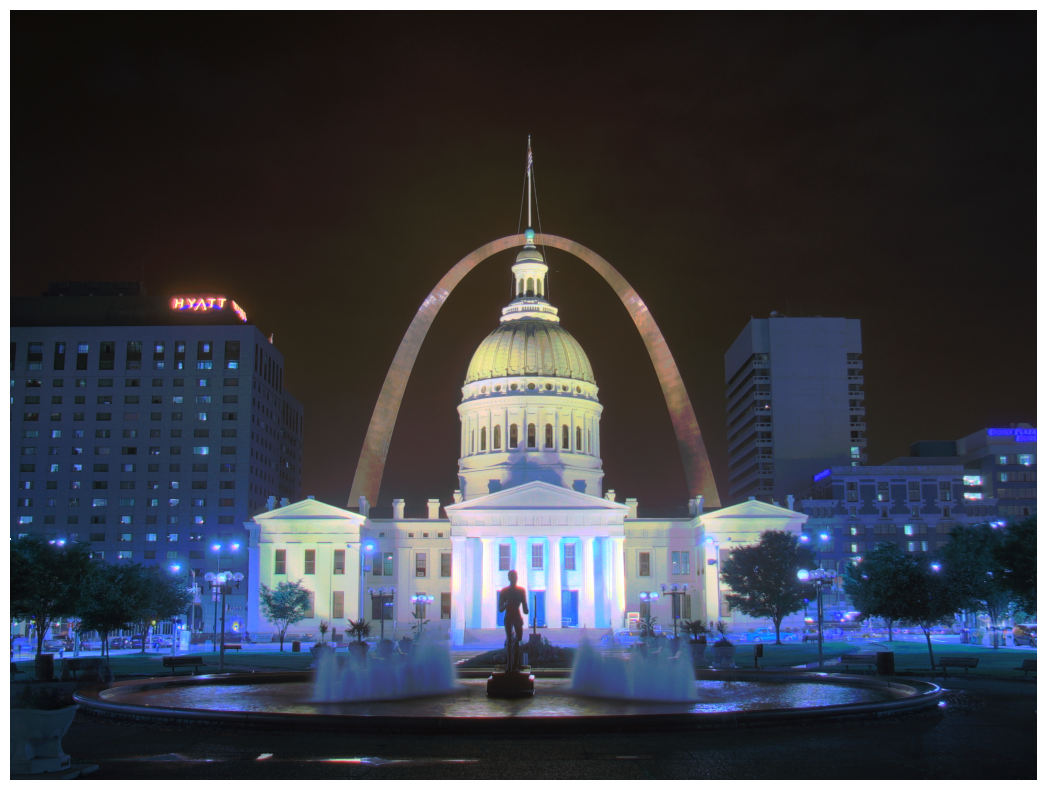

In [ ]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

cv2.imwrite("ldr-Drago.jpg", 255*ldrDrago)
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1)[:,:,::-1]);plt.axis("off");

Tonemaping using Reinhard's method ... 


(np.float64(-0.5), np.float64(2815.5), np.float64(2111.5), np.float64(-0.5))

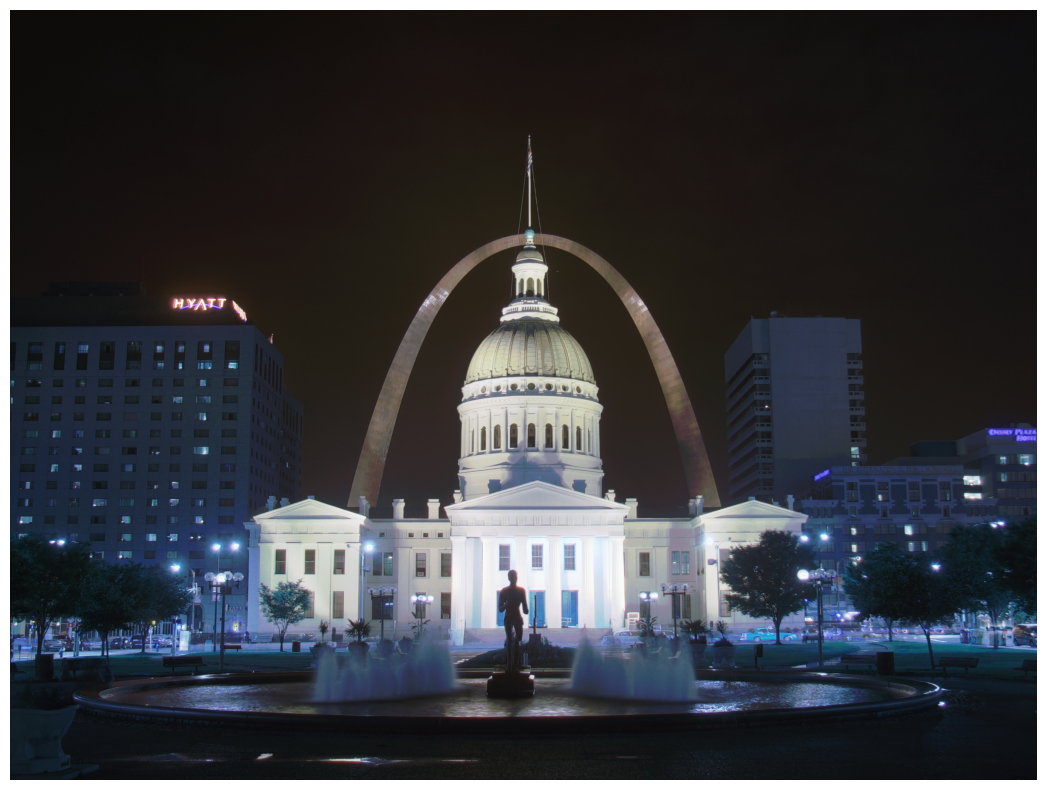

In [ ]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)

cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrReinhard, 0, 1)[:,:,::-1]);plt.axis("off")

Tonemaping using Mantiuk's method ... 


(np.float64(-0.5), np.float64(2815.5), np.float64(2111.5), np.float64(-0.5))

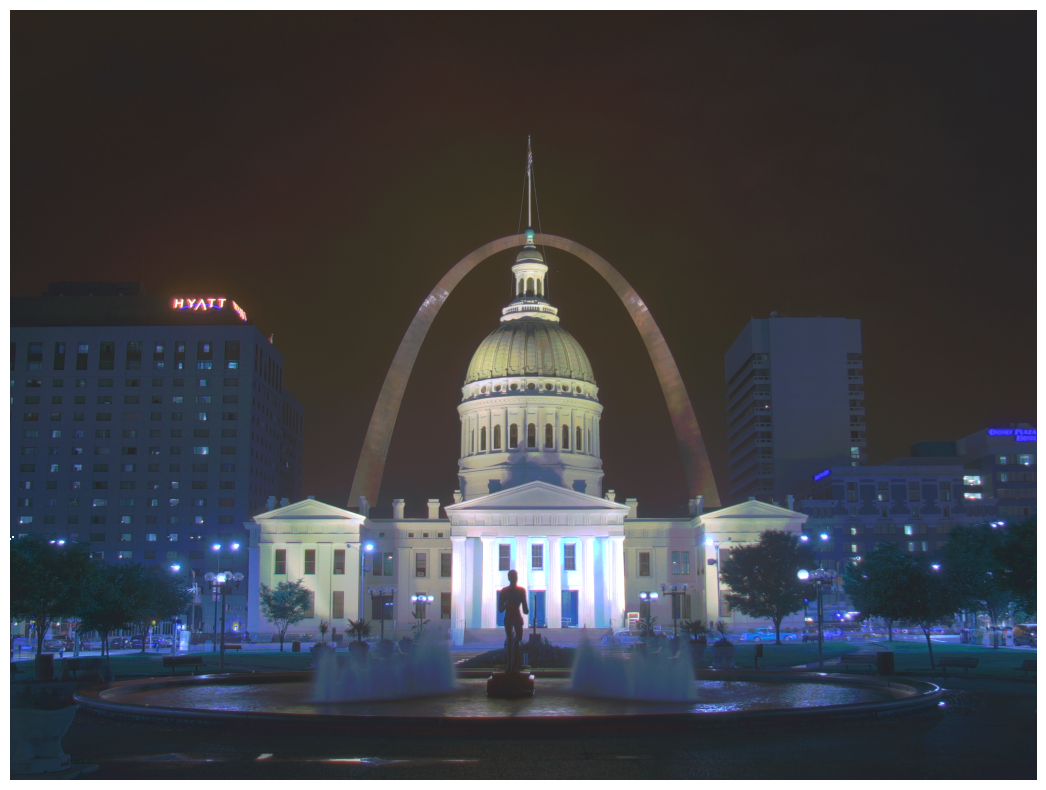

In [ ]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk

cv2.imwrite("ldr-Mantiuk.jpg", ldrMantiuk * 255)
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrMantiuk, 0, 1)[:,:,::-1]);plt.axis("off")